In [4]:
%logstop
%logstart -rtq ~/.logs/DS_Pandas.py append
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144

In [5]:
import expectexception

# Pandas

<!-- requirement: data/yelp.json.gz -->
<!-- requirement: data/PEP_2016_PEPANNRES.csv -->

In [6]:
import pandas as pd

We introduced the Pandas module and the DataFrame object in the lesson on [basic data science modules](DS_Basic_DS_Modules.ipynb). We learned how to construct a DataFrame, add data, retrieve data, and [basic reading and writing to disk](DS_IO.ipynb). Now we'll explore the DataFrame object and its powerful analysis methods in more depth.

We'll work with a data set from the online review site, Yelp. The file is stored as a compressed JSON file.

In [7]:
!ls -lh ./data/yelp.json.gz

-rw-rw-r-- 1 jovyan users 4.2M May 12 15:15 ./data/yelp.json.gz


In [8]:
import gzip
import simplejson as json

with gzip.open('./data/yelp.json.gz', 'r') as f:
    yelp_data = [json.loads(line) for line in f]
    
yelp_df = pd.DataFrame(yelp_data)
yelp_df.head()    

,business_id,full_address,hours,open,categories,city,review_count,name,neighborhoods,longitude,state,stars,latitude,attributes,type
0,vcNAWiLM4dR7D2nwwJ7nCA,"4840 E Indian School Rd\nSte 101\nPhoenix, AZ ...","{'Tuesday': {'close': '17:00', 'open': '08:00'...",True,"[Doctors, Health & Medical]",Phoenix,7,"Eric Goldberg, MD",[],-111.983758,AZ,3.5,33.499313,{'By Appointment Only': True},business
1,JwUE5GmEO-sH1FuwJgKBlQ,"6162 US Highway 51\nDe Forest, WI 53532",{},True,[Restaurants],De Forest,26,Pine Cone Restaurant,[],-89.335844,WI,4.0,43.238893,"{'Take-out': True, 'Good For': {'dessert': Fal...",business
2,uGykseHzyS5xAMWoN6YUqA,"505 W North St\nDe Forest, WI 53532","{'Monday': {'close': '22:00', 'open': '06:00'}...",True,"[American (Traditional), Restaurants]",De Forest,16,Deforest Family Restaurant,[],-89.353437,WI,4.0,43.252267,"{'Take-out': True, 'Good For': {'dessert': Fal...",business
3,LRKJF43s9-3jG9Lgx4zODg,"4910 County Rd V\nDe Forest, WI 53532","{'Monday': {'close': '22:00', 'open': '10:30'}...",True,"[Food, Ice Cream & Frozen Yogurt, Fast Food, R...",De Forest,7,Culver's,[],-89.374983,WI,4.5,43.251045,"{'Take-out': True, 'Wi-Fi': 'free', 'Takes Res...",business
4,RgDg-k9S5YD_BaxMckifkg,"631 S Main St\nDe Forest, WI 53532","{'Monday': {'close': '22:00', 'open': '11:00'}...",True,"[Chinese, Restaurants]",De Forest,3,Chang Jiang Chinese Kitchen,[],-89.343722,WI,4.0,43.240875,"{'Take-out': True, 'Has TV': False, 'Outdoor S...",business


## Pandas DataFrame and Series

The Pandas DataFrame is a highly structured object. Each row corresponds with some physical entity or event. We think of all of the information in a given row as referring to one object (e.g. a business). Each column contains one type of data, both semantically (e.g. names, counts of reviews, star ratings) and syntactically.

In [9]:
yelp_df.dtypes

business_id       object
full_address      object
hours             object
open                bool
categories        object
city              object
review_count       int64
name              object
neighborhoods     object
longitude        float64
state             object
stars            float64
latitude         float64
attributes        object
type              object
dtype: object

We can reference the columns by name, like we would with a `dict`.

In [10]:
yelp_df['city'].head()

0      Phoenix
1    De Forest
2    De Forest
3    De Forest
4    De Forest
Name: city, dtype: object

In [11]:
type(yelp_df['city'])

pandas.core.series.Series

An individual column is a Pandas `Series`. A `Series` has a `name` and a `dtype` (similar to a NumPy array). A `DataFrame` is essentially a `dict` of `Series` objects. The `Series` has an `index` attribute, which label the rows. The index is essentially a set of keys for referencing the rows. We can have an index composed of numbers, strings, timestamps, or any hashable Python object. The index will also have homogeneous type.

In [12]:
yelp_df['city'].index

RangeIndex(start=0, stop=37938, step=1)

The `DataFrame` has an `index` given by the union of indices of its constituent `Series` (we'll explore this later in more detail). Since a `DataFrame` is a `dict` of `Series`, we can select a column and then a row using square bracket notation, but not the reverse (however, the `loc` method works around this).

In [13]:
# this works
yelp_df['city'][100]

'Madison'

In [14]:
%%expect_exception KeyError

# this doesn't
yelp_df[100]['city']

---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexes/base.py in get_loc(self, key, method, tolerance)
   2889             try:
-> 2890                 return self._engine.get_loc(key)
   2891             except KeyError:

pandas/_libs/index.pyx in pandas._libs.index.IndexEngine.get_loc()

pandas/_libs/index.pyx in pandas._libs.index.IndexEngine.get_loc()

pandas/_libs/hashtable_class_helper.pxi in pandas._libs.hashtable.PyObjectHashTable.get_item()

pandas/_libs/hashtable_class_helper.pxi in pandas._libs.hashtable.PyObjectHashTable.get_item()

KeyError: 100

During handling of the above exception, another exception occurred:

KeyError                                  Traceback (most recent call last)
<ipython-input-14-a719463eea94> in <module>()
      1 
      2 # this doesn't
----> 3 yelp_df[100]['city']

/opt/conda/lib/python3.7

In [15]:
yelp_df.loc[100, 'city']

'Madison'

Understanding the underlying structure of the `DataFrame` object as a `dict` of `Series` will help you avoid errors and help you think about how the `DataFrame` should behave when we begin doing more complicated analysis.

We can _aggregate_ data in a `DataFrame` using methods like `mean`, `sum`, `count`, and `std`. To view a collection of summary statistics for each column we can use the `describe` method.

In [16]:
yelp_df.describe()

,review_count,longitude,stars,latitude
count,37938.000000,37938.000000,37938.000000,37938.000000
mean,29.300648,-104.097172,3.672914,36.530288
std,92.893064,28.365375,0.888730,5.822588
min,3.000000,-115.369725,1.000000,32.876638
25%,4.000000,-115.136389,3.000000,33.476739
50%,8.000000,-112.068820,3.500000,33.680247
75%,21.000000,-111.883274,4.500000,36.141875
max,4084.000000,-3.050088,5.000000,56.033777


The utility of a DataFrame comes from its ability to split data into groups, using the `groupby` method, and then perform custom aggregations using the `apply` or `aggregate` method. This process of splitting the data into groups, applying an aggregation, and then collecting the results is [discussed in detail in the Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/groupby.html), and is one of the main focuses of this notebook.

## DataFrame construction

Since a `DataFrame` is a `dict` of `Series`, the natural way to construct a `DataFrame` is to use a `dict` of `Series`-like objects.

In [17]:
from string import ascii_letters, digits
import numpy as np
import datetime

In [18]:
usernames = ['alice36', 'bob_smith', 'eve']

passwords = [''.join(np.random.choice(list(ascii_letters + digits), 8)) for x in range(3)]
creation_dates = [datetime.datetime.now().date() - datetime.timedelta(int(x)) for x in np.random.randint(0, 1500, 3)]

In [19]:
df = pd.DataFrame({'username': usernames, 'password': passwords, 'date-created': pd.to_datetime(creation_dates)})
df

,username,password,date-created
0,alice36,5Kd2lc3d,2016-10-10
1,bob_smith,pg1pu1RS,2016-11-07
2,eve,lSJJnEDa,2019-09-11


In [20]:
df.dtypes

username                object
password                object
date-created    datetime64[ns]
dtype: object

The `DataFrame` is also closely related to the NumPy `ndarray`.

In [21]:
random_data = np.random.random((4,3))
random_data

array([[0.87321743, 0.99344481, 0.50882145],
       [0.03446946, 0.12477396, 0.94452941],
       [0.26699572, 0.75293214, 0.03100494],
       [0.88608188, 0.81873187, 0.90001512]])

In [22]:
df_random = pd.DataFrame(random_data, columns=['a', 'b', 'c'])
df_random

,a,b,c
0,0.873217,0.993445,0.508821
1,0.034469,0.124774,0.944529
2,0.266996,0.752932,0.031005
3,0.886082,0.818732,0.900015


To add a new column or row, we simply use `dict`-like assignment.

In [23]:
emails = ['alice.chan@gmail.com', 'bwsmith1983@gmail.com', 'fakemail123@yahoo.com']
df['email'] = emails
df

,username,password,date-created,email
0,alice36,5Kd2lc3d,2016-10-10,alice.chan@gmail.com
1,bob_smith,pg1pu1RS,2016-11-07,bwsmith1983@gmail.com
2,eve,lSJJnEDa,2019-09-11,fakemail123@yahoo.com


In [24]:
# loc references index value, NOT position
# for position use iloc
df.loc[3] = ['2015-01-29', '38uzFJ1n', 'melvintherobot', 'moviesrgood@moviesrgood.com']
df

,username,password,date-created,email
0,alice36,5Kd2lc3d,2016-10-10 00:00:00,alice.chan@gmail.com
1,bob_smith,pg1pu1RS,2016-11-07 00:00:00,bwsmith1983@gmail.com
2,eve,lSJJnEDa,2019-09-11 00:00:00,fakemail123@yahoo.com
3,2015-01-29,38uzFJ1n,melvintherobot,moviesrgood@moviesrgood.com


We can also drop columns and rows.

In [25]:
df.drop(3)

,username,password,date-created,email
0,alice36,5Kd2lc3d,2016-10-10 00:00:00,alice.chan@gmail.com
1,bob_smith,pg1pu1RS,2016-11-07 00:00:00,bwsmith1983@gmail.com
2,eve,lSJJnEDa,2019-09-11 00:00:00,fakemail123@yahoo.com


In [26]:
# to drop a column, need axis=1
df.drop('email', axis=1)

,username,password,date-created
0,alice36,5Kd2lc3d,2016-10-10 00:00:00
1,bob_smith,pg1pu1RS,2016-11-07 00:00:00
2,eve,lSJJnEDa,2019-09-11 00:00:00
3,2015-01-29,38uzFJ1n,melvintherobot


Notice when we dropped the `'email'` column, the row at index 3 was in the `DataFrame`, even though we just dropped it! Most operations in Pandas return a _copy_ of the `DataFrame`, rather than modifying the `DataFrame` object itself. Therefore, in order to permanently alter the `DataFrame`, we either need to reassign the `df` variable, or use the `inplace` keyword.

In [27]:
df.drop(3, inplace=True)
df

,username,password,date-created,email
0,alice36,5Kd2lc3d,2016-10-10 00:00:00,alice.chan@gmail.com
1,bob_smith,pg1pu1RS,2016-11-07 00:00:00,bwsmith1983@gmail.com
2,eve,lSJJnEDa,2019-09-11 00:00:00,fakemail123@yahoo.com


Since the `index` and column names are important for interacting with data in the DataFrame, we should make sure to set them to useful values. We can do this during construction or after.

In [28]:
df = pd.DataFrame({'email': emails, 'password': passwords, 'date-created': creation_dates}, index=usernames)
df.index.name = 'users' # it can be helpful to give the index a name
df

,email,password,date-created
users,,,
alice36,alice.chan@gmail.com,5Kd2lc3d,2016-10-10
bob_smith,bwsmith1983@gmail.com,pg1pu1RS,2016-11-07
eve,fakemail123@yahoo.com,lSJJnEDa,2019-09-11


In [29]:
# alternatively
df = pd.DataFrame(list(zip(usernames, emails, passwords, creation_dates)))
df

,0,1,2,3
0,alice36,alice.chan@gmail.com,5Kd2lc3d,2016-10-10
1,bob_smith,bwsmith1983@gmail.com,pg1pu1RS,2016-11-07
2,eve,fakemail123@yahoo.com,lSJJnEDa,2019-09-11


In [30]:
df.columns = ['username', 'email', 'password', 'date-created']
df.set_index('username', inplace=True)
df

,email,password,date-created
username,,,
alice36,alice.chan@gmail.com,5Kd2lc3d,2016-10-10
bob_smith,bwsmith1983@gmail.com,pg1pu1RS,2016-11-07
eve,fakemail123@yahoo.com,lSJJnEDa,2019-09-11


In [31]:
# to reset index to a column
df.reset_index(inplace=True)
df

,username,email,password,date-created
0,alice36,alice.chan@gmail.com,5Kd2lc3d,2016-10-10
1,bob_smith,bwsmith1983@gmail.com,pg1pu1RS,2016-11-07
2,eve,fakemail123@yahoo.com,lSJJnEDa,2019-09-11


We can have multiple levels to an index. We'll discover that for some data sets it is necessary to have multiple levels to the index in order to uniquely identify a row.

In [32]:
df.set_index(['username', 'email'])

,,password,date-created
username,email,,
alice36,alice.chan@gmail.com,5Kd2lc3d,2016-10-10
bob_smith,bwsmith1983@gmail.com,pg1pu1RS,2016-11-07
eve,fakemail123@yahoo.com,lSJJnEDa,2019-09-11


### Reading data from file

We can also construct a DataFrame using data stored in a file or received from a website. The data source might be [JSON](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_json.html), [HTML](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_html.html), [CSV](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html#pandas.read_csv), [Excel](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_excel.html), [Python pickle](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_pickle.html), or even a [database connection](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql.html). Each format will have its own methods for reading and writing data that take different arguments. The arguments of these methods usually depend on the particular formatting of the file. For example, the values in a CSV might be separate by commas or semi-colons, it might have a header or it might not.

The `read_csv` method has to deal with the most formatting possibilities, so we will explore that method with a few examples. Try to apply these ideas when working with other file formats, but keep in mind that each format and read method is different. Always check [the Pandas documentation](http://pandas.pydata.org/pandas-docs/stable/io.html) when having trouble with reading or writing data.

In [33]:
csv = [','.join(map(lambda x: str(x), row)) for row in np.vstack([df.columns, df])]
with open('./data/read_csv_example.csv', 'w') as f:
    [f.write(line + '\n') for line in csv]

!cat ./data/read_csv_example.csv

username,email,password,date-created
alice36,alice.chan@gmail.com,5Kd2lc3d,2016-10-10
bob_smith,bwsmith1983@gmail.com,pg1pu1RS,2016-11-07
eve,fakemail123@yahoo.com,lSJJnEDa,2019-09-11


In [34]:
pd.read_csv('./data/read_csv_example.csv')

,username,email,password,date-created
0,alice36,alice.chan@gmail.com,5Kd2lc3d,2016-10-10
1,bob_smith,bwsmith1983@gmail.com,pg1pu1RS,2016-11-07
2,eve,fakemail123@yahoo.com,lSJJnEDa,2019-09-11


In [35]:
# we can also set an index from the data
pd.read_csv('./data/read_csv_example.csv', index_col=0)

,email,password,date-created
username,,,
alice36,alice.chan@gmail.com,5Kd2lc3d,2016-10-10
bob_smith,bwsmith1983@gmail.com,pg1pu1RS,2016-11-07
eve,fakemail123@yahoo.com,lSJJnEDa,2019-09-11


In [36]:
# what if our data had no header?
with open('./data/read_csv_noheader_example.csv', 'w') as f:
    [f.write(line + '\n') for i, line in enumerate(csv) if i != 0]
    
!cat ./data/read_csv_noheader_example.csv

alice36,alice.chan@gmail.com,5Kd2lc3d,2016-10-10
bob_smith,bwsmith1983@gmail.com,pg1pu1RS,2016-11-07
eve,fakemail123@yahoo.com,lSJJnEDa,2019-09-11


In [37]:
pd.read_csv('./data/read_csv_noheader_example.csv', names=['username', 'email', 'password', 'date-created'], header=None)

,username,email,password,date-created
0,alice36,alice.chan@gmail.com,5Kd2lc3d,2016-10-10
1,bob_smith,bwsmith1983@gmail.com,pg1pu1RS,2016-11-07
2,eve,fakemail123@yahoo.com,lSJJnEDa,2019-09-11


In [38]:
# what if our data was tab-delimited?
tsv = ['\t'.join(map(lambda x: str(x), row)) for row in np.vstack([df.columns, df])]
with open('./data/read_csv_example.tsv', 'w') as f:
    [f.write(line + '\n') for line in tsv]

!cat ./data/read_csv_example.tsv

username	email	password	date-created
alice36	alice.chan@gmail.com	5Kd2lc3d	2016-10-10
bob_smith	bwsmith1983@gmail.com	pg1pu1RS	2016-11-07
eve	fakemail123@yahoo.com	lSJJnEDa	2019-09-11


In [39]:
pd.read_csv('./data/read_csv_example.tsv', delimiter='\t')

,username,email,password,date-created
0,alice36,alice.chan@gmail.com,5Kd2lc3d,2016-10-10
1,bob_smith,bwsmith1983@gmail.com,pg1pu1RS,2016-11-07
2,eve,fakemail123@yahoo.com,lSJJnEDa,2019-09-11


Even within a single file format, data can be arranged and formatted in many ways. These have been just a few examples of the kinds of arguments you might need to use with `read_csv` in order to read data into a DataFrame in an organized way.

## Filtering DataFrames

One of the powerful analytical tools of the Pandas DataFrame is its syntax for filtering data. Often we'll only want to work with a certain subset of our data based on some criteria. Let's look at our Yelp data for an example.

In [40]:
yelp_df.head()

,business_id,full_address,hours,open,categories,city,review_count,name,neighborhoods,longitude,state,stars,latitude,attributes,type
0,vcNAWiLM4dR7D2nwwJ7nCA,"4840 E Indian School Rd\nSte 101\nPhoenix, AZ ...","{'Tuesday': {'close': '17:00', 'open': '08:00'...",True,"[Doctors, Health & Medical]",Phoenix,7,"Eric Goldberg, MD",[],-111.983758,AZ,3.5,33.499313,{'By Appointment Only': True},business
1,JwUE5GmEO-sH1FuwJgKBlQ,"6162 US Highway 51\nDe Forest, WI 53532",{},True,[Restaurants],De Forest,26,Pine Cone Restaurant,[],-89.335844,WI,4.0,43.238893,"{'Take-out': True, 'Good For': {'dessert': Fal...",business
2,uGykseHzyS5xAMWoN6YUqA,"505 W North St\nDe Forest, WI 53532","{'Monday': {'close': '22:00', 'open': '06:00'}...",True,"[American (Traditional), Restaurants]",De Forest,16,Deforest Family Restaurant,[],-89.353437,WI,4.0,43.252267,"{'Take-out': True, 'Good For': {'dessert': Fal...",business
3,LRKJF43s9-3jG9Lgx4zODg,"4910 County Rd V\nDe Forest, WI 53532","{'Monday': {'close': '22:00', 'open': '10:30'}...",True,"[Food, Ice Cream & Frozen Yogurt, Fast Food, R...",De Forest,7,Culver's,[],-89.374983,WI,4.5,43.251045,"{'Take-out': True, 'Wi-Fi': 'free', 'Takes Res...",business
4,RgDg-k9S5YD_BaxMckifkg,"631 S Main St\nDe Forest, WI 53532","{'Monday': {'close': '22:00', 'open': '11:00'}...",True,"[Chinese, Restaurants]",De Forest,3,Chang Jiang Chinese Kitchen,[],-89.343722,WI,4.0,43.240875,"{'Take-out': True, 'Has TV': False, 'Outdoor S...",business


We see the Yelp data set has a `'state'` column. If we are only interested in businesses in Arizona (AZ), we can filter the DataFrame and select only that data.

In [41]:
az_yelp_df = yelp_df[yelp_df['state'] == 'AZ']
az_yelp_df.head()

,business_id,full_address,hours,open,categories,city,review_count,name,neighborhoods,longitude,state,stars,latitude,attributes,type
0,vcNAWiLM4dR7D2nwwJ7nCA,"4840 E Indian School Rd\nSte 101\nPhoenix, AZ ...","{'Tuesday': {'close': '17:00', 'open': '08:00'...",True,"[Doctors, Health & Medical]",Phoenix,7,"Eric Goldberg, MD",[],-111.983758,AZ,3.5,33.499313,{'By Appointment Only': True},business
297,x5Mv61CnZLohZWxfCVCPTQ,"2819 N Central Ave\nPhoenix, AZ 85004",{},True,"[Sandwiches, Pizza, Chicken Wings, Restaurants]",Phoenix,12,Domino's Pizza,[],-112.073418,AZ,2.5,33.479542,"{'Take-out': True, 'Wi-Fi': 'no', 'Alcohol': '...",business
298,2ZnCITVa0abGce4gZ6RhIw,"1850 N Central Ave\nPhoenix, AZ 85004",{},True,"[American (New), Sandwiches, Restaurants]",Phoenix,5,Viad Tower Restaurants,[],-112.074315,AZ,3.5,33.468988,"{'Take-out': True, 'Noise Level': 'quiet', 'De...",business
299,EmzaQR5hQlF0WIl24NxAZA,"132 E Washington St\nPhoenix, AZ 85004","{'Sunday': {'close': '02:00', 'open': '21:00'}...",True,"[American (New), Nightlife, Dance Clubs, Resta...",Phoenix,20,Sky Lounge,[],-112.071702,AZ,2.5,33.448399,"{'Alcohol': 'full_bar', 'Price Range': 1, 'Noi...",business
300,SiwN7f0N4bs4ZtPc4yPgiA,"710 N Central Ave\nPhoenix, AZ 85004",{},True,"[Nightlife, Dance Clubs]",Phoenix,15,Palazzo,[],-112.074225,AZ,2.5,33.456068,"{'Price Range': 2, 'Alcohol': 'full_bar', 'Goo...",business


In [42]:
az_yelp_df['state'].unique()

array(['AZ'], dtype=object)

We can combine criteria using logic. What if we're only interested in businesses with more than 10 reviews in Arizona?

In [43]:
yelp_df[(yelp_df['state'] == 'AZ') & (yelp_df['review_count'] > 10)].head()

,business_id,full_address,hours,open,categories,city,review_count,name,neighborhoods,longitude,state,stars,latitude,attributes,type
297,x5Mv61CnZLohZWxfCVCPTQ,"2819 N Central Ave\nPhoenix, AZ 85004",{},True,"[Sandwiches, Pizza, Chicken Wings, Restaurants]",Phoenix,12,Domino's Pizza,[],-112.073418,AZ,2.5,33.479542,"{'Take-out': True, 'Wi-Fi': 'no', 'Alcohol': '...",business
299,EmzaQR5hQlF0WIl24NxAZA,"132 E Washington St\nPhoenix, AZ 85004","{'Sunday': {'close': '02:00', 'open': '21:00'}...",True,"[American (New), Nightlife, Dance Clubs, Resta...",Phoenix,20,Sky Lounge,[],-112.071702,AZ,2.5,33.448399,"{'Alcohol': 'full_bar', 'Price Range': 1, 'Noi...",business
300,SiwN7f0N4bs4ZtPc4yPgiA,"710 N Central Ave\nPhoenix, AZ 85004",{},True,"[Nightlife, Dance Clubs]",Phoenix,15,Palazzo,[],-112.074225,AZ,2.5,33.456068,"{'Price Range': 2, 'Alcohol': 'full_bar', 'Goo...",business
301,M-MFa0YErVBbFW2IJhGJmw,"386 E Virginia Ave\nPhoenix, AZ 85004","{'Tuesday': {'close': '18:00', 'open': '07:30'...",True,"[Auto Repair, Automotive, Tires, Oil Change St...",Phoenix,28,Virginia Auto Service,[],-112.065806,AZ,4.0,33.476784,{},business
302,KPoTixdjoJxSqRSEApSAGg,"2631 N Central Ave\nPhoenix, AZ 85004","{'Monday': {'close': '21:00', 'open': '11:00'}...",True,"[Thai, Restaurants]",Phoenix,281,Wild Thaiger,[],-112.073524,AZ,4.0,33.477934,"{'Take-out': True, 'Wi-Fi': 'no', 'Good For': ...",business


How does this filtering work?

When we write `yelp_df['state'] == 'AZ'`, Pandas selects the `'state'` column and checks whether each row is `'AZ'`. If so, that row is marked `True`, and if not, it is marked `False`. This is how we would normally expect a conditional to work, only now applied to an entire Pandas `Series`. We end up with a Pandas `Series` of Boolean variables.

In [44]:
(yelp_df['state'] == 'AZ').head()

0     True
1    False
2    False
3    False
4    False
Name: state, dtype: bool

We can use a `Series` (or any similar object) of Boolean variables to index the DataFrame.

In [45]:
df

,username,email,password,date-created
0,alice36,alice.chan@gmail.com,5Kd2lc3d,2016-10-10
1,bob_smith,bwsmith1983@gmail.com,pg1pu1RS,2016-11-07
2,eve,fakemail123@yahoo.com,lSJJnEDa,2019-09-11


In [46]:
df[[True, False, True]]

,username,email,password,date-created
0,alice36,alice.chan@gmail.com,5Kd2lc3d,2016-10-10
2,eve,fakemail123@yahoo.com,lSJJnEDa,2019-09-11


This let's us filter a DataFrame using idiomatic logical expressions like `yelp_df['review_count'] > 10`.

As another example, let's consider the `'open'` column, which is a `True`/`False` flag for whether a business is open. This is also a Boolean Pandas `Series`, so we can just use it directly.

In [47]:
# the open businesses
yelp_df[yelp_df['open']].head()

,business_id,full_address,hours,open,categories,city,review_count,name,neighborhoods,longitude,state,stars,latitude,attributes,type
0,vcNAWiLM4dR7D2nwwJ7nCA,"4840 E Indian School Rd\nSte 101\nPhoenix, AZ ...","{'Tuesday': {'close': '17:00', 'open': '08:00'...",True,"[Doctors, Health & Medical]",Phoenix,7,"Eric Goldberg, MD",[],-111.983758,AZ,3.5,33.499313,{'By Appointment Only': True},business
1,JwUE5GmEO-sH1FuwJgKBlQ,"6162 US Highway 51\nDe Forest, WI 53532",{},True,[Restaurants],De Forest,26,Pine Cone Restaurant,[],-89.335844,WI,4.0,43.238893,"{'Take-out': True, 'Good For': {'dessert': Fal...",business
2,uGykseHzyS5xAMWoN6YUqA,"505 W North St\nDe Forest, WI 53532","{'Monday': {'close': '22:00', 'open': '06:00'}...",True,"[American (Traditional), Restaurants]",De Forest,16,Deforest Family Restaurant,[],-89.353437,WI,4.0,43.252267,"{'Take-out': True, 'Good For': {'dessert': Fal...",business
3,LRKJF43s9-3jG9Lgx4zODg,"4910 County Rd V\nDe Forest, WI 53532","{'Monday': {'close': '22:00', 'open': '10:30'}...",True,"[Food, Ice Cream & Frozen Yogurt, Fast Food, R...",De Forest,7,Culver's,[],-89.374983,WI,4.5,43.251045,"{'Take-out': True, 'Wi-Fi': 'free', 'Takes Res...",business
4,RgDg-k9S5YD_BaxMckifkg,"631 S Main St\nDe Forest, WI 53532","{'Monday': {'close': '22:00', 'open': '11:00'}...",True,"[Chinese, Restaurants]",De Forest,3,Chang Jiang Chinese Kitchen,[],-89.343722,WI,4.0,43.240875,"{'Take-out': True, 'Has TV': False, 'Outdoor S...",business


In [48]:
# the closed businesses
yelp_df[~yelp_df['open']].head()

,business_id,full_address,hours,open,categories,city,review_count,name,neighborhoods,longitude,state,stars,latitude,attributes,type
5,oLctHIA1AxmsgOuu4dM6Vw,"4156 County Rd B\nMc Farland, WI 53558",{},False,"[Television Stations, Mass Media]",Mc Farland,10,Charter Communications,[],-89.322920,WI,1.5,42.968507,{},business
14,HxPpZSY6Q1eARuiahhra6A,"6401 University Ave\nMiddleton, WI 53562",{},False,"[Event Planning & Services, Party & Event Plan...",Middleton,5,Crandalls Carryout & Catering,[],-89.491800,WI,4.0,43.093265,"{'Take-out': True, 'Caters': True, 'Attire': '...",business
16,77ESrCo7hQ96VpCWWdvoxg,"6230 University Ave\nMiddleton, WI 53562","{'Monday': {'close': '21:00', 'open': '06:00'}...",False,"[Mexican, Restaurants]",Middleton,17,Mi Cocina,[],-89.487487,WI,3.0,43.091061,"{'Take-out': True, 'Wi-Fi': 'no', 'Good For': ...",business
50,IEmqrFe96NOhU07TA0rZdw,"6625 Century Ave\nMiddleton, WI 53562",{},False,"[American (Traditional), Restaurants]",Middleton,7,Stamm House At Pheasant Branch,[],-89.494422,WI,2.0,43.104535,"{'Alcohol': 'full_bar', 'Attire': 'casual', 'P...",business
62,mbtGl2I2A2To-8jiggN99g,"6661 University Ave\nSte 103\nMiddleton, WI 53562","{'Tuesday': {'close': '20:00', 'open': '10:00'...",False,"[Skin Care, Hair Salons, Beauty & Spas]",Middleton,7,Tangles,[],-89.497265,WI,2.0,43.096650,"{'By Appointment Only': True, 'Parking': {'gar...",business


Notice in an earlier expression we wrote `(yelp_df['state'] == 'AZ') & (yelp_df['review_count'] > 10)`. Normally in Python we use the word `and` when we are working with logic. In Pandas we have to use _bit-wise_ logical operators; all that's important to know is the following equivalencies:

`~` = `not`  
`&` = `and`  
`|` = `or`  

We can also use Panda's built-in [string operations](https://pandas.pydata.org/pandas-docs/stable/text.html) for doing pattern matching. For example, there are a lot of businesses in Las Vegas in our data set. However, there are also businesses in 'Las Vegas East' and 'South Las Vegas'. To get all of the Las Vegas businesses I might do the following.

In [49]:
vegas_yelp_df = yelp_df[yelp_df['city'].str.contains('Vegas')]
vegas_yelp_df.head()

,business_id,full_address,hours,open,categories,city,review_count,name,neighborhoods,longitude,state,stars,latitude,attributes,type
4348,uzztTCsg3XAKlYqmLO40aw,"5835 S Eastern Ave\nSoutheast\nLas Vegas, NV 8...","{'Monday': {'close': '21:00', 'open': '10:00'}...",True,"[Arts & Entertainment, Shopping, Books, Mags, ...",Las Vegas,7,Psychic Eye Book Shops,[Southeast],-115.119422,NV,4.5,36.083936,"{'Parking': {'garage': False, 'street': False,...",business
4360,IspFZDcpu9W5NvvJ7QgJZg,The Forum Shops At Caesars\n3500 Las Vegas Blv...,"{'Monday': {'close': '21:00', 'open': '10:00'}...",True,"[Women's Clothing, Men's Clothing, Fashion, Sh...",Las Vegas,6,Gap,[Eastside],-115.146372,NV,4.5,36.124423,"{'Parking': {'garage': True, 'street': False, ...",business
4364,Dvulg9cc3XHkt5DkBUekhw,467 E Silverado Ranch Blvd\nSte 175\nSoutheast...,{},True,"[Hair Salons, Beauty & Spas]",Las Vegas,10,Great Clips,[Southeast],-115.153303,NV,2.5,36.012150,"{'By Appointment Only': False, 'Parking': {'ga...",business
4441,_SM8UKIwBNbmj1r629ipoQ,"1916 Village Center Cir\nSummerlin\nLas Vegas,...","{'Monday': {'close': '23:00', 'open': '11:00'}...",False,"[Wine Bars, Bars, Restaurants, Nightlife, Ital...",Las Vegas,9,Chianti Cafe,[Summerlin],-115.304396,NV,3.5,36.192414,"{'Alcohol': 'full_bar', 'Music': {'video': Fal...",business
4489,Zaw0IAXwopKX4MV23MHQRw,"2718 E Tropicana Avenue\nEastside\nLas Vegas, ...",{},True,"[Car Wash, Automotive]",Las Vegas,3,Terrible Herbst,"[Eastside, Southeast]",-115.113492,NV,1.5,36.100507,{},business


In [50]:
vegas_yelp_df['city'].unique()

array(['Las Vegas', 'North Las Vegas', 'N Las Vegas', 'N. Las Vegas',
       'C Las Vegas', 'Las Vegas ', 'Las Vegas, NV 89147',
       'Las Vegas East', 'North Las Vegas ', 'N E Las Vegas',
       'N W Las Vegas', 'Lake Las Vegas', 'South Las Vegas'], dtype=object)

## Applying functions and data aggregation

To analyze the data in the dataframe, we'll need to be able to apply functions to it. Pandas has many mathematical functions built in already, and DataFrames and Series can be passed to NumPy functions (since they behave like NumPy arrays).

In [51]:
log_review_count = np.log(yelp_df['review_count'])
print(log_review_count.head())
print(log_review_count.shape)

0    1.945910
1    3.258097
2    2.772589
3    1.945910
4    1.098612
Name: review_count, dtype: float64
(37938,)


In [52]:
mean_review_count = yelp_df['review_count'].mean()
print(mean_review_count)

29.300648426379883


In the first example we took the _logarithm_ of the review count for each business. In the second case, we calculated the mean review count of all businesses. In the first case, we ended up with a number for each business. We _transformed_ the review counts using the logarithm. In the second case, we _summarized_ the review counts of all the businesses in one number. This summary is a form of _data aggregation_, in which we take many data points and combine them into some smaller representation. The functions we apply to our data sets will either be in the category of **transformations** or **aggregations**.

Sometimes we will need to transform our data in order for it to be usable. For instance, in the `'attributes'` column of our DataFrame, we have a `dict` for each business listing all of its properties. If I wanted to find a restaurant that offers delivery service, it would be difficult for me to filter the DataFrame, even though that information is in the `'attributes'` column. First, I need to transform the `dict` into something more useful.

In [53]:
def get_delivery_attr(attr_dict):
    return attr_dict.get('Delivery')

If we give this function a `dict` from the `'attributes'` column, it will look for the `'Delivery'` key. If it finds that key, it returns the value. If it doesn't find the key, it will return none.

In [54]:
print(get_delivery_attr(yelp_df.loc[0, 'attributes']))
print(get_delivery_attr(yelp_df.loc[1, 'attributes']))
print(get_delivery_attr(yelp_df.loc[2, 'attributes']))

None
False
False


We could iterate over the rows of `yelp_df['attributes']` to get all of the values, but there is a better way. DataFrames and Series have an `apply` method that allows us to apply our function to the entire data set at once, like we did earlier with `np.log`.

In [55]:
delivery_attr = yelp_df['attributes'].apply(get_delivery_attr)
delivery_attr.head()

0     None
1    False
2    False
3    False
4     None
Name: attributes, dtype: object

We can make a new column in our DataFrame with this transformed (and useful) information.

In [56]:
yelp_df['delivery'] = delivery_attr

# to find businesses that deliver
yelp_df[yelp_df['delivery'].fillna(False)].head()

,business_id,full_address,hours,open,categories,city,review_count,name,neighborhoods,longitude,state,stars,latitude,attributes,type,delivery
21,KTqNU4plO23583DYAMGXYg,"2411 Allen Blvd\nMiddleton, WI 53562",{},True,"[Sandwiches, Pizza, Chicken Wings, Restaurants]",Middleton,3,Domino's Pizza,[],-89.486219,WI,3.0,43.100384,"{'Take-out': True, 'Takes Reservations': False...",business,True
64,oc0rCahXOaJeHLzzDdSfyA,"1901 Cayuga St\nMiddleton, WI 53562",{},False,[Restaurants],Middleton,3,Soup Factory,[],-89.513737,WI,3.0,43.096359,"{'Take-out': True, 'Alcohol': 'none', 'Takes R...",business,True
75,OC8AUJshLVimn_-P_INvJw,"330 W Main St\nSun Prairie, WI 53590","{'Monday': {'close': '23:00', 'open': '11:00'}...",True,"[Sandwiches, Pizza, Chicken Wings, Restaurants]",Sun Prairie,4,Pizza Pit,[],-89.218527,WI,2.5,43.183277,"{'Take-out': True, 'Good For': {'dessert': Fal...",business,True
79,NDAxF0_RCZBQedVO_d5WnA,"984 W Main St\nSun Prairie, WI 53590",{},True,"[Chinese, Restaurants]",Sun Prairie,9,Chang Jiang,[],-89.230477,WI,3.0,43.180786,"{'Take-out': True, 'Wi-Fi': 'no', 'Good For': ...",business,True
82,5uxhIGZlJm9g_zfG_83z5Q,"2091 McCoy Rd\nSun Prairie, WI 53590",{},True,"[Chinese, Restaurants]",Sun Prairie,6,Peking Chinese Restaurant,[],-89.248245,WI,3.0,43.175381,"{'Delivery': True, 'Waiter Service': True, 'Ta...",business,True


It's less common (though possible) to use `apply` on an entire DataFrame rather than just one column. Since a DataFrame might contain many types of data, we won't usually want to apply the same transformation or aggregation across all of the columns.

## Data aggregation with `groupby`

Data aggregation is an [_overloaded_](https://en.wikipedia.org/wiki/Function_overloading) term. It refers to both data summarization (as above) but also to the combining of different data sets.

With our Yelp data, we might be interested in comparing the star ratings of businesses in different cities. We could calculate the mean star rating for each city, and this would allow us to easily compare them. First we would have to split up our data by city, calculate the mean for each city, and then combine it back at the end. This procedure is known as [split-apply-combine](https://pandas.pydata.org/pandas-docs/stable/groupby.html) and is a classic example of data aggregation (in the sense of both summarizing data and also combining different data sets).

We achieve the splitting and recombining using the `groupby` method.

In [57]:
stars_by_city = yelp_df.groupby('city')['stars'].mean()
stars_by_city.head()

city
Ahwatukee          3.687500
Anthem             3.781818
Apache Junction    3.637500
Arcadia            5.000000
Atlanta            3.500000
Name: stars, dtype: float64

We can also apply multiple functions at once. It might be helpful to know the standard deviation of star ratings, the total number of reviews, and the count of businesses as well.

In [58]:
agg_by_city = yelp_df.groupby('city').agg({'stars': ['mean', 'std'], 'review_count': 'sum', 'business_id': 'count'})
agg_by_city.head()

stars           review_count business_id
                     mean       std          sum       count
city                                                        
Ahwatukee        3.687500  1.066955          258           8
Anthem           3.781818  0.756231          727          55
Apache Junction  3.637500  1.028010          853          80
Arcadia          5.000000       NaN            4           1
Atlanta          3.500000       NaN           16           1

In [59]:
# unstacking the columns
new_columns = map(lambda x: '_'.join(x),
                  zip(agg_by_city.columns.get_level_values(0),
                      agg_by_city.columns.get_level_values(1)))
agg_by_city.columns = new_columns
agg_by_city.head()

,stars_mean,stars_std,review_count_sum,business_id_count
city,,,,
Ahwatukee,3.687500,1.066955,258,8
Anthem,3.781818,0.756231,727,55
Apache Junction,3.637500,1.028010,853,80
Arcadia,5.000000,NaN,4,1
Atlanta,3.500000,NaN,16,1


How does this work? What does `groupby` do? Let's start by inspecting the result of `groupby`.

In [60]:
by_city = yelp_df.groupby('city')
by_city

In [61]:
dir(by_city)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_accessors',
 '_add_numeric_operations',
 '_agg_examples_doc',
 '_agg_see_also_doc',
 '_aggregate',
 '_aggregate_generic',
 '_aggregate_item_by_item',
 '_aggregate_multiple_funcs',
 '_apply_filter',
 '_apply_to_column_groupbys',
 '_apply_whitelist',
 '_assure_grouper',
 '_block_agg_axis',
 '_bool_agg',
 '_builtin_table',
 '_choose_path',
 '_concat_objects',
 '_constructor',
 '_cumcount_array',
 '_cython_agg_blocks',
 '_cython_agg_general',
 '_cython_table',
 '_cython_transform',
 '_decide_output_index',
 '_def_str',
 '_define_paths',
 '_deprecations',
 '_dir_additi

In [62]:
print(type(by_city.groups))
list(by_city.groups.items())[:5]

<class 'dict'>


[('Ahwatukee',
  Int64Index([1718, 1740, 13572, 17787, 20361, 22856, 28608, 30499], dtype='int64')),
 ('Anthem',
  Int64Index([ 1946,  1948,  1949,  1950,  1951,  1952,  1953,  1954,  1955,
               1956,  1957,  1958,  1961,  1962, 11455, 12008, 12572, 12870,
              13007, 13069, 13286, 13500, 13636, 13703, 13744, 13827, 13935,
              15483, 15581, 15756, 19358, 21295, 21303, 21327, 22354, 22428,
              22654, 22782, 23215, 24937, 25026, 26116, 26300, 26331, 26841,
              26937, 30039, 30170, 31565, 32525, 33027, 33492, 33983, 34663,
              35433],
             dtype='int64')),
 ('Apache Junction',
  Int64Index([ 2392,  2393,  2394,  2395,  2396,  2397,  2398,  2399,  2400,
               2401,  2402,  2403,  2404,  2406,  2407,  2408,  2409,  2410,
               2412,  2413,  2414,  2415,  2417,  2418,  2419,  7305,  7524,
               7525,  7528,  7529,  7530,  7531,  7532,  7533,  7534, 10813,
              11315, 11660, 12662, 12858, 12

In [63]:
by_city.get_group('Anthem').head()

,business_id,full_address,hours,open,categories,city,review_count,name,neighborhoods,longitude,state,stars,latitude,attributes,type,delivery
1946,Y0Ife2OJPs5QSL-7dyMF5Q,"4250 W Anthem Way\nSte 375\nAnthem, AZ 85086",{},True,"[Fashion, Shopping, Shoe Stores]",Anthem,8,Nike Factory Store,[],-112.150162,AZ,4.0,33.874003,"{'Parking': {'garage': False, 'street': False,...",business,None
1948,v1ocqAm5soWTNPttLQhSZw,"3434 W Anthem Way\nSte 118\nAnthem, AZ 85086",{},True,"[Chinese, Restaurants]",Anthem,50,Shanghai Club,[],-112.135305,AZ,3.5,33.864429,"{'Take-out': True, 'Wi-Fi': 'no', 'Good For': ...",business,False
1949,HMDymN9TbFUln9AkqHMpVw,"4250 W Anthem Way\nAnthem, AZ 85086",{},True,"[Department Stores, Fashion, Shopping]",Anthem,3,Polo Ralph Lauren Factory Store,[],-112.151046,AZ,3.0,33.875410,"{'Parking': {'garage': False, 'street': False,...",business,None
1950,XJv7dUb5fMRaZAWVZjhtvw,"4250 W Anthem Way\nAnthem, AZ 85086",{},True,"[Shopping, Outlet Stores]",Anthem,64,Outlets At Anthem,[],-112.149875,AZ,3.5,33.873311,"{'Parking': {'garage': False, 'street': False,...",business,None
1951,xPDbCj9tfp5nnGzYzoCHwA,"3655 W Anthem Way\nSte C105\nAnthem, AZ 85086",{},True,"[Sandwiches, Restaurants]",Anthem,6,Subway,[],-112.138854,AZ,3.0,33.864913,"{'Ambience': {'romantic': False, 'intimate': F...",business,None


When we use `groupby` on a column, Pandas builds a `dict`, using the unique elements of the column as the keys and the index of the rows in each group as the values. This `dict` is stored in the `groups` attribute. Pandas can then use this `dict` to direct the application of aggregating functions over the different groups.

## Sorting

Even though the DataFrame in many ways behaves similarly to a `dict`, it also is ordered. Therefore we can sort the data in it. Pandas provides two sorting methods, `sort_values` and `sort_index`.

In [64]:
yelp_df.sort_values('stars').head()

,business_id,full_address,hours,open,categories,city,review_count,name,neighborhoods,longitude,state,stars,latitude,attributes,type,delivery
36220,2Q2tZ0yQo25cni0PT2j0Zw,"6420 Spring Mountain Rd\nChinatown\nLas Vegas,...",{},True,"[Real Estate Services, Property Management, Ho...",Las Vegas,3,Total Real Eatate of Nevada,[Chinatown],-115.232316,NV,1.0,36.125870,{},business,None
27946,cHvL85QIV-L2-YlLOcwlCw,"5235 S Kyrene Rd\nSte 106\nTempe, AZ 85283","{'Monday': {'close': '18:00', 'open': '10:00'}...",True,"[Sporting Goods, Shopping, Golf Equipment, Out...",Tempe,3,Custom Golf Center,[],-111.945955,AZ,1.0,33.376734,{},business,None
36332,e23Sa3FCTaIOSZzJsT8sIQ,"3949 N Drinkwater Blvd\nScottsdale, AZ 85251",{},True,"[Professional Services, Internet Service Provi...",Scottsdale,3,Cox Cable,[],-111.921620,AZ,1.0,33.493469,{},business,None
7488,fZO5Fghc6Q07jU8EROzj6Q,"2431 E Laurel St\nMesa, AZ 85213",{},True,"[Home Services, Pool Cleaners]",Mesa,6,Foster's Pool Service & Repair,[],-111.778212,AZ,1.0,33.457833,{},business,None
3370,JjdjS5n6ILh-d3GeTD6qkA,"15820 N 84th St\nSte 25\nScottsdale, AZ 85260","{'Monday': {'close': '17:00', 'open': '09:00'}...",True,"[Hotels & Travel, Motorcycle Rental]",Scottsdale,3,Top Spoke Rentals,[],-111.900187,AZ,1.0,33.629858,{},business,None


In [65]:
yelp_df.set_index('business_id').sort_index().head()

,full_address,hours,open,categories,city,review_count,name,neighborhoods,longitude,state,stars,latitude,attributes,type,delivery
business_id,,,,,,,,,,,,,,,
--1emggGHgoG6ipd_RMb-g,"3280 S Decatur Blvd\nWestside\nLas Vegas, NV 8...",{},True,"[Food, Convenience Stores]",Las Vegas,4,Sinclair,[Westside],-115.207238,NV,4.0,36.130531,"{'Parking': {'garage': False, 'street': False,...",business,None
--4Pe8BZ6gj57VFL5mUE8g,"21001 North Tatum Blvd. #24\nPhoenix, AZ 85050",{},True,"[Shopping, Office Equipment]",Phoenix,5,Office Max,[],-111.974607,AZ,3.0,33.678615,"{'Parking': {'garage': False, 'street': False,...",business,None
--5jkZ3-nUPZxUvtcbr8Uw,"1336 N Scottsdale Rd\nScottsdale, AZ 85257","{'Monday': {'close': '21:00', 'open': '11:00'}...",True,"[Greek, Restaurants]",Scottsdale,42,Mika's Greek,[],-111.926908,AZ,4.5,33.463373,"{'Take-out': True, 'Wi-Fi': 'no', 'Good For': ...",business,False
--BlvDO_RG2yElKu9XA1_g,"14870 N Northsight Blvd\nSte 103\nScottsdale, ...","{'Monday': {'close': '21:00', 'open': '10:30'}...",True,"[Sushi Bars, Hawaiian, Chinese, Restaurants]",Scottsdale,65,Asian Island,[],-111.897836,AZ,4.0,33.620568,"{'Take-out': True, 'Wi-Fi': 'free', 'Good For'...",business,True
--Dl2rW_xO8GuYBomlg9zw,"4505 S Maryland Pkwy\nUniversity\nLas Vegas, N...",{},True,"[Medical Centers, Health & Medical]",Las Vegas,6,UNLV Student Health Center,[University],-115.141514,NV,4.0,36.110940,{'By Appointment Only': True},business,None


Don't forget that most Pandas operations return a copy of the DataFrame, and do not update the DataFrame in place (unless we tell it to)!

## Joining data sets

Often we will want to augment one data set with data from another. For instance, businesses in big cities probably get more reviews than those in small cities. It could be useful to scale the review counts by the city's population. To do that, we'll need to add population data to the Yelp data. We can get population data from the US census.

In [66]:
census = pd.read_csv('./data/PEP_2016_PEPANNRES.csv', skiprows=[1])

census.head()

,GEO.id,GEO.id2,GEO.display-label,rescen42010,resbase42010,respop72010,respop72011,respop72012,respop72013,respop72014,respop72015,respop72016
0,0610000US0900104720,900104720,"Bethel town, Fairfield County, Connecticut",18584.0,18584,18642,18942,19150,19267,19316,19463,19627
1,0610000US0900108070,900108070,"Bridgeport town, Fairfield County, Connecticut",144229.0,144236,144912,146226,146962,147666,147560,147090,145936
2,0610000US0900108980,900108980,"Brookfield town, Fairfield County, Connecticut",16452.0,16452,16483,16635,16785,16859,17016,17087,17098
3,0610000US0900118500,900118500,"Danbury town, Fairfield County, Connecticut",80893.0,80903,81356,82182,82788,83678,83687,84236,84992
4,0610000US0900118850,900118850,"Darien town, Fairfield County, Connecticut",20732.0,20732,20777,20975,21127,21342,21641,21718,21744


In [67]:
# construct city & state fields
census['city'] = census['GEO.display-label'].apply(lambda x: x.split(', ')[0])
census['state'] = census['GEO.display-label'].apply(lambda x: x.split(', ')[2])

In [68]:
# convert state names to abbreviations

print(census['state'].unique())

['Connecticut' 'Illinois' 'Indiana' 'Kansas' 'Maine' 'Massachusetts'
 'Michigan' 'Minnesota' 'Missouri' 'Nebraska' 'New Hampshire' 'New Jersey'
 'New York' 'North Dakota' 'Ohio' 'Pennsylvania' 'Rhode Island'
 'South Dakota' 'Vermont' 'Wisconsin']


In [69]:
state_abbr = dict(zip(census['state'].unique(), ['CT', 'IL', 'IN', 'KS', 'ME', 'MA', 'MI', 'MN', 'MO', 'NE', 'NH', 'NJ', 'NY', 'ND', 'OH', 'PA', 'RI', 'SD', 'VT', 'WI']))

In [70]:
census['state'] = census['state'].replace(state_abbr)

In [71]:
# remove last word (e.g. 'city', 'town', township', 'borough', 'village') from city names

census['city'] = census['city'].apply(lambda x: ' '.join(x.split(' ')[:-1]))

In [72]:
merged_df = yelp_df.merge(census, on=['state', 'city'])
merged_df.head()

,business_id,full_address,hours,open,categories,city,review_count,name,neighborhoods,longitude,...,GEO.display-label,rescen42010,resbase42010,respop72010,respop72011,respop72012,respop72013,respop72014,respop72015,respop72016
0,HxPpZSY6Q1eARuiahhra6A,"6401 University Ave\nMiddleton, WI 53562",{},False,"[Event Planning & Services, Party & Event Plan...",Middleton,5,Crandalls Carryout & Catering,[],-89.491800,...,"Middleton city, Dane County, Wisconsin",17442.0,17558,17622,17903,18271,18522,18694,18955,19109
1,HxPpZSY6Q1eARuiahhra6A,"6401 University Ave\nMiddleton, WI 53562",{},False,"[Event Planning & Services, Party & Event Plan...",Middleton,5,Crandalls Carryout & Catering,[],-89.491800,...,"Middleton town, Dane County, Wisconsin",5877.0,5831,5845,5943,6030,6086,6140,6179,6257
2,SKLw05kEIlZcpTD5pqma8Q,"2039 Allen Blvd\nMiddleton, WI 53562","{'Monday': {'close': '14:00', 'open': '11:00'}...",True,"[Party & Event Planning, Asian Fusion, Event P...",Middleton,41,Imperial Garden Chinese Restaurant,[],-89.485169,...,"Middleton city, Dane County, Wisconsin",17442.0,17558,17622,17903,18271,18522,18694,18955,19109
3,SKLw05kEIlZcpTD5pqma8Q,"2039 Allen Blvd\nMiddleton, WI 53562","{'Monday': {'close': '14:00', 'open': '11:00'}...",True,"[Party & Event Planning, Asian Fusion, Event P...",Middleton,41,Imperial Garden Chinese Restaurant,[],-89.485169,...,"Middleton town, Dane County, Wisconsin",5877.0,5831,5845,5943,6030,6086,6140,6179,6257
4,77ESrCo7hQ96VpCWWdvoxg,"6230 University Ave\nMiddleton, WI 53562","{'Monday': {'close': '21:00', 'open': '06:00'}...",False,"[Mexican, Restaurants]",Middleton,17,Mi Cocina,[],-89.487487,...,"Middleton city, Dane County, Wisconsin",17442.0,17558,17622,17903,18271,18522,18694,18955,19109


The `merge` function looks through the `'state'` and `'city'` columns of `yelp_df` and `census` and tries to match up rows that share values. When a match is found, the rows are combined. What happens when a match is not found? We can imagine four scenarios:  

1. We only keep rows from `yelp_df` and `census` if they match. Any rows from either table that have no match are discarded. This is called an _inner join_.  

2. We keep all rows from `yelp_df` and `census`, even if they have no match. In this case, when a row in `yelp_df` has no match in `census`, all the columns from `census` are merged in with null values. When a row in `census` has no match in `yelp_df`, all the columns from `yelp_df` are merged in with null values. This is called an _outer join_.

3. We privilege the `yelp_df` data. If a row in `yelp_df` has no match in `census`, we keep it and fill in the missing `census` columns as null values. If a row in `census` has no match in `yelp_df`, we discard it. This is called a _left join_.

4. We privilege the `census` data. This is called a _right join_.

The default behavior for Pandas is case #1, the _inner join_. This means if there are cities in `yelp_df` that we don't have matching `census` data for, they are dropped. Therefore, `merged_df` might be smaller than `yelp_df`.

In [73]:
print(yelp_df.shape)
print(merged_df.shape)

(37938, 16)
(3598, 28)


There are a lot of cities in `yelp_df` that aren't in `census`! We might want to keep these rows, but we don't need any census data where there are no businesses. Then we should use a _left join_.

In [74]:
merged_df = yelp_df.merge(census, on=['state', 'city'], how='left')
print(yelp_df.shape)
print(merged_df.shape)

(37938, 16)
(39648, 28)


Sometimes we don't need to merge together the columns of separate data sets, but just need to add more rows. For example, the New York City subway system [releases data about how many customers enter and exit the station each week](http://web.mta.info/developers/turnstile.html). Each weekly data set has the same columns, so if we want multiple weeks of data, we just have to append one week to another.

In [75]:
nov18 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_171118.txt')
nov11 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_171111.txt')

In [76]:
nov18.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/11/2017,03:00:00,REGULAR,6402636,2166100
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/11/2017,07:00:00,REGULAR,6402645,2166112
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/11/2017,11:00:00,REGULAR,6402717,2166175
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/11/2017,15:00:00,REGULAR,6402857,2166230
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/11/2017,19:00:00,REGULAR,6403178,2166292


In [77]:
nov11.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/04/2017,00:00:00,REGULAR,6393563,2162811
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/04/2017,04:00:00,REGULAR,6393595,2162822
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/04/2017,08:00:00,REGULAR,6393616,2162855
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/04/2017,12:00:00,REGULAR,6393742,2162933
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/04/2017,16:00:00,REGULAR,6394021,2162992


In [78]:
nov = pd.concat([nov18, nov11])
nov['DATE'].unique()

array(['11/11/2017', '11/12/2017', '11/13/2017', '11/14/2017',
       '11/15/2017', '11/16/2017', '11/17/2017', '11/04/2017',
       '11/05/2017', '11/06/2017', '11/07/2017', '11/08/2017',
       '11/09/2017', '11/10/2017'], dtype=object)

We can also use `concat` to perform inner and outer joins based on index. For example, we can perform some data aggregation and then join the results onto the original DataFrame.

In [79]:
city_counts = yelp_df.groupby('city')['business_id'].count().rename('city_counts')
city_counts.head()

city
Ahwatukee           8
Anthem             55
Apache Junction    80
Arcadia             1
Atlanta             1
Name: city_counts, dtype: int64

In [80]:
pd.concat([yelp_df.set_index('city'), city_counts], axis=1, join='inner').reset_index().head()

,city,business_id,full_address,hours,open,categories,review_count,name,neighborhoods,longitude,state,stars,latitude,attributes,type,delivery,city_counts
0,Phoenix,vcNAWiLM4dR7D2nwwJ7nCA,"4840 E Indian School Rd\nSte 101\nPhoenix, AZ ...","{'Tuesday': {'close': '17:00', 'open': '08:00'...",True,"[Doctors, Health & Medical]",7,"Eric Goldberg, MD",[],-111.983758,AZ,3.5,33.499313,{'By Appointment Only': True},business,None,6715
1,De Forest,JwUE5GmEO-sH1FuwJgKBlQ,"6162 US Highway 51\nDe Forest, WI 53532",{},True,[Restaurants],26,Pine Cone Restaurant,[],-89.335844,WI,4.0,43.238893,"{'Take-out': True, 'Good For': {'dessert': Fal...",business,False,6
2,De Forest,uGykseHzyS5xAMWoN6YUqA,"505 W North St\nDe Forest, WI 53532","{'Monday': {'close': '22:00', 'open': '06:00'}...",True,"[American (Traditional), Restaurants]",16,Deforest Family Restaurant,[],-89.353437,WI,4.0,43.252267,"{'Take-out': True, 'Good For': {'dessert': Fal...",business,False,6
3,De Forest,LRKJF43s9-3jG9Lgx4zODg,"4910 County Rd V\nDe Forest, WI 53532","{'Monday': {'close': '22:00', 'open': '10:30'}...",True,"[Food, Ice Cream & Frozen Yogurt, Fast Food, R...",7,Culver's,[],-89.374983,WI,4.5,43.251045,"{'Take-out': True, 'Wi-Fi': 'free', 'Takes Res...",business,False,6
4,De Forest,RgDg-k9S5YD_BaxMckifkg,"631 S Main St\nDe Forest, WI 53532","{'Monday': {'close': '22:00', 'open': '11:00'}...",True,"[Chinese, Restaurants]",3,Chang Jiang Chinese Kitchen,[],-89.343722,WI,4.0,43.240875,"{'Take-out': True, 'Has TV': False, 'Outdoor S...",business,None,6


Pandas provides [extensive documentation](https://pandas.pydata.org/pandas-docs/stable/merging.html) with diagrammed examples on different methods and approaches for joining data.

## Working with time series
Pandas has a well-designed backend for inferring dates and times from strings and doing meaningful computations with them. 

In [81]:
pop_growth = pd.read_html('https://web.archive.org/web/20170127165708/https://www.census.gov/population/international/data/worldpop/table_population.php', attrs={'class': 'query_table'}, parse_dates=[0])[0]
pop_growth.dropna(inplace=True)
pop_growth.head()

,Year,Population,Annual Growth Rate (%),Annual Population Change
0,1950-01-01,2.557629e+09,1.459,37311223.0
1,1951-01-01,2.594940e+09,1.612,41832429.0
2,1952-01-01,2.636772e+09,1.717,45281083.0
3,1953-01-01,2.682053e+09,1.796,48174715.0
4,1954-01-01,2.730228e+09,1.900,51870839.0


By setting the `'Year'` column to the index, we can easily aggregate data by date using the `resample` method. The `resample` method allows us to decrease or increase the sampling frequency of our data. For instance, maybe instead of yearly data, we want to see average quantities for each decade.

In [82]:
pop_growth.set_index('Year', inplace=True)

In [83]:
pop_growth.resample('10AS').mean()

,Population,Annual Growth Rate (%),Annual Population Change
Year,,,
1950-01-01,2.765922e+09,1.7529,48537285.4
1960-01-01,3.321900e+09,2.0094,66969623.4
1970-01-01,4.047646e+09,1.8154,73179902.2
1980-01-01,4.813578e+09,1.7438,83875618.4
1990-01-01,5.651506e+09,1.4220,80123197.0
2000-01-01,6.429734e+09,1.2017,77213097.9
2010-01-01,7.206287e+09,1.0742,77318221.4
2020-01-01,7.949758e+09,0.8687,68934817.8
2030-01-01,8.587652e+09,0.6741,57810604.6


This kind of resampling is called _downsampling_, because we are decreasing the sampling frequency of the data. We can choose how to aggregate the data from each decade (e.g. `mean`). Options for aggregation include `mean`, `median`, `sum`, `last`, and `first`.

We can also _upsample_ data. In this case, we don't have data for each quarter, so we have to tell Pandas has to fill in the missing data.

In [84]:
pop_growth.resample('1Q').bfill().head()

,Population,Annual Growth Rate (%),Annual Population Change
Year,,,
1950-03-31,2.594940e+09,1.612,41832429.0
1950-06-30,2.594940e+09,1.612,41832429.0
1950-09-30,2.594940e+09,1.612,41832429.0
1950-12-31,2.594940e+09,1.612,41832429.0
1951-03-31,2.636772e+09,1.717,45281083.0


In [85]:
pop_growth.resample('1Q').ffill().head()

,Population,Annual Growth Rate (%),Annual Population Change
Year,,,
1950-03-31,2.557629e+09,1.459,37311223.0
1950-06-30,2.557629e+09,1.459,37311223.0
1950-09-30,2.557629e+09,1.459,37311223.0
1950-12-31,2.557629e+09,1.459,37311223.0
1951-03-31,2.594940e+09,1.612,41832429.0


Pandas' time series capabilities are built on the Pandas `Timestamp` class.

In [86]:
print(pd.Timestamp('January 8, 2017'))
print(pd.Timestamp('01/08/17 20:13'))
print(pd.Timestamp(1.4839*10**18))

2017-01-08 00:00:00
2017-01-08 20:13:00
2017-01-08 18:26:40


In [87]:
print(pd.Timestamp('Feb. 11 2016 2:30 am') - pd.Timestamp('2015-08-03 5:14 pm'))

191 days 09:16:00


In [88]:
from pandas.tseries.offsets import BDay, Day, BMonthEnd

print(pd.Timestamp('January 9, 2017') - Day(4))
print(pd.Timestamp('January 9, 2017') - BDay(4))
print(pd.Timestamp('January 9, 2017') + BMonthEnd(4))

2017-01-05 00:00:00
2017-01-03 00:00:00
2017-04-28 00:00:00


If we're entering time series data into a DataFrame it will often be useful to create a range of dates.

In [89]:
pd.date_range(start='1/8/2017', end='3/2/2017', freq='B')

DatetimeIndex(['2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12',
               '2017-01-13', '2017-01-16', '2017-01-17', '2017-01-18',
               '2017-01-19', '2017-01-20', '2017-01-23', '2017-01-24',
               '2017-01-25', '2017-01-26', '2017-01-27', '2017-01-30',
               '2017-01-31', '2017-02-01', '2017-02-02', '2017-02-03',
               '2017-02-06', '2017-02-07', '2017-02-08', '2017-02-09',
               '2017-02-10', '2017-02-13', '2017-02-14', '2017-02-15',
               '2017-02-16', '2017-02-17', '2017-02-20', '2017-02-21',
               '2017-02-22', '2017-02-23', '2017-02-24', '2017-02-27',
               '2017-02-28', '2017-03-01', '2017-03-02'],
              dtype='datetime64[ns]', freq='B')

The `Timestamp` class is compatible with Python's `datetime` module.

In [90]:
import datetime

pd.Timestamp('May 1, 2017') - datetime.datetime(2017, 1, 8)

Timedelta('113 days 00:00:00')

## Visualizing data with Pandas

Visualizing a data set is an important first step in drawing insights. We can easily pass data from Pandas to Matplotlib for visualizations, but Pandas also plugs into Matplotlib directly through methods like `plot` and `hist`.

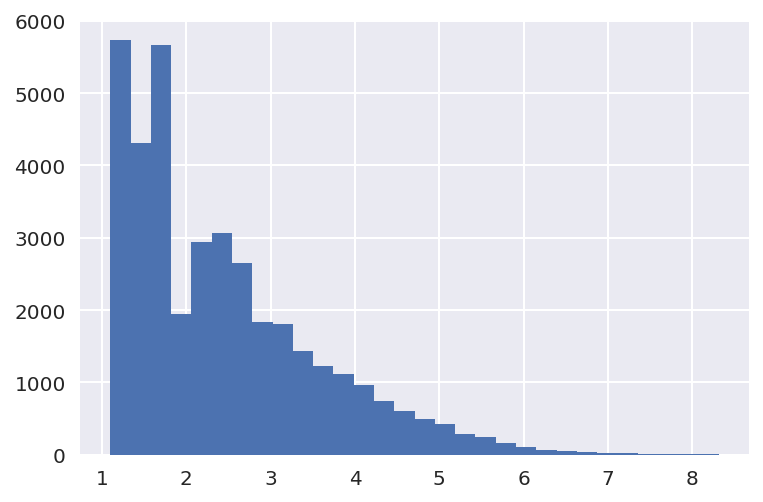

In [91]:
yelp_df['review_count'].apply(np.log).hist(bins=30)

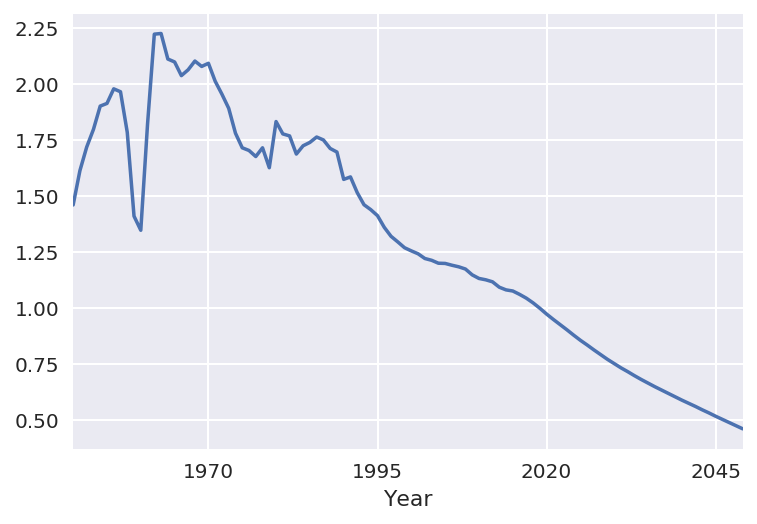

In [92]:
pop_growth['Annual Growth Rate (%)'].plot()

The [plotting functions take many parameters](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html) for customizing the appearance of the output. Since they are essentially a wrapper around the Matplotlib functions, they also accept many of the Matplotlib parameters, not all of which are listed in the Pandas documentation. Pandas provides [a guide](https://pandas.pydata.org/pandas-docs/stable/visualization.html) to making various plots from DataFrames.

*Copyright &copy; 2020 The Data Incubator.  All rights reserved.*